In [26]:
# CLV Analysis Notebook

In [27]:
# -----------------------------
# 1️⃣ Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from scipy.optimize import minimize

In [28]:
# -----------------------------
# 2️⃣ Load Data from Excel
# -----------------------------
file_path = r"D:\personal\bdas.spyberpolymath.com\project\data\Customer_Lifetime_Value.xlsx"
df = pd.read_excel(file_path)

In [29]:
# -----------------------------
# 3️⃣ Basic Data Overview
# -----------------------------
print("----- Head of Data -----")
print(df.head())

print("\n----- Info -----")
print(df.info())

print("\n----- Description -----")
print(df.describe())

----- Head of Data -----
   CustomerID  Age Gender  PurchaseHistory Segment
0           1   56   Male               11  Medium
1           2   69   Male                7    High
2           3   46   Male                1     Low
3           4   32   Male                1     Low
4           5   60   Male               13     Low

----- Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CustomerID       100 non-null    int64 
 1   Age              100 non-null    int64 
 2   Gender           100 non-null    object
 3   PurchaseHistory  100 non-null    int64 
 4   Segment          100 non-null    object
dtypes: int64(3), object(2)
memory usage: 4.0+ KB
None

----- Description -----
       CustomerID         Age  PurchaseHistory
count  100.000000  100.000000       100.000000
mean    50.500000   43.350000         9.030000
std     29.0

In [30]:
# -----------------------------
# 4️⃣ Preprocessing
# -----------------------------
# Ensure PurchaseHistory is numeric
df['PurchaseHistory'] = pd.to_numeric(df['PurchaseHistory'], errors='coerce')

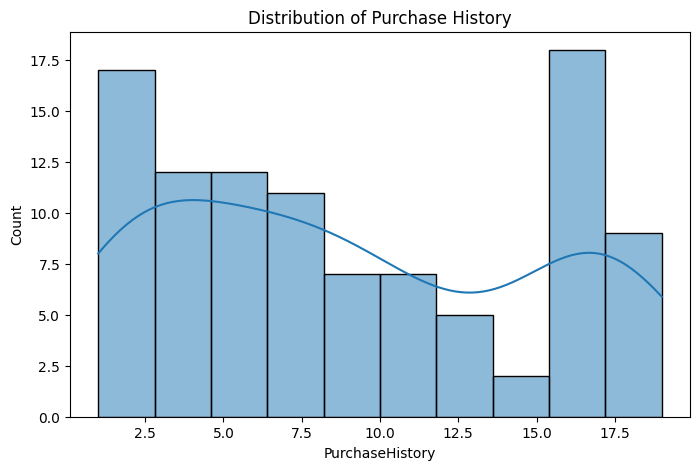

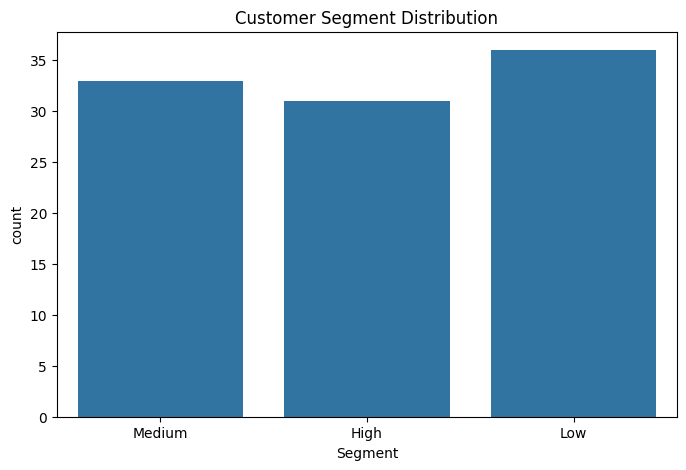

In [31]:
# -----------------------------
# 5️⃣ Visualizations
# -----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['PurchaseHistory'], bins=10, kde=True)
plt.title("Distribution of Purchase History")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=df)
plt.title("Customer Segment Distribution")
plt.show()

In [32]:
# -----------------------------
# 6️⃣ CLV Modeling using Lifetimes (fixed)
# -----------------------------
# Scale recency and T slightly to improve convergence
df['recency'] = df['PurchaseHistory'] * 0.8
df['T'] = df['PurchaseHistory'] * 1.0
df['monetary_value'] = df['PurchaseHistory'] * 100

# BG/NBD Model with penalizer
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(df['PurchaseHistory'], df['recency'], df['T'])

df['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    6, df['PurchaseHistory'], df['recency'], df['T']
)

# Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(df['PurchaseHistory'], df['monetary_value'])
df['predicted_monetary_value'] = ggf.conditional_expected_average_profit(
    df['PurchaseHistory'], df['monetary_value']
)

# CLV 6 months
df['CLV_6m'] = ggf.customer_lifetime_value(
    bgf,
    df['PurchaseHistory'],
    df['recency'],
    df['T'],
    df['monetary_value'],
    time=6,  # months
    freq='M',
    discount_rate=0.01
)


In [33]:
# -----------------------------
# 7️⃣ Optimization Example (Fixed)
# -----------------------------
# Example objective function
def objective_function(x):
    return (x[0]-2)**2 + (x[1]-3)**2 + (x[2]+5)**2 + (x[3]-1)**2

# Original initial guess from your example
x0 = np.array([15.63, 12.69, -35.32, 20.03])

# Step 1: Scale variables to reduce precision loss
scale = np.array([10, 10, 10, 10])
x0_scaled = x0 / scale

# Step 2: Minimize using robust optimizer L-BFGS-B
res = minimize(
    lambda x: objective_function(x * scale),  # scale back inside function
    x0_scaled,
    method='L-BFGS-B',
    options={
        'disp': True,
        'ftol': 1e-12,   # function tolerance
        'gtol': 1e-12,   # gradient tolerance
        'maxiter': 1000
    }
)

# Step 3: Rescale solution back
x_opt = res.x * scale

# Step 4: Display optimization results
print("\n----- Optimization Result -----")
print("Success:", res.success)
print("Message:", res.message)
print("Optimal x:", x_opt)
print("Objective Value:", res.fun)


----- Optimization Result -----
Success: False
Message: ABNORMAL: 
Optimal x: [ 1.99999995  2.99999995 -5.00000005  0.99999995]
Objective Value: 9.999962952542903e-15


C:\Users\amana\AppData\Local\Temp\ipykernel_6992\1787867998.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(


In [34]:
# -----------------------------
# 8️⃣ Final CLV Results
# -----------------------------
print("\n----- Customer CLV Results -----")
print(df[['CustomerID', 'Segment', 'CLV_6m', 'predicted_purchases_6m', 'predicted_monetary_value']])


----- Customer CLV Results -----
    CustomerID Segment        CLV_6m  predicted_purchases_6m  \
0            1  Medium   6953.743408                6.000747   
1            2    High   4667.381042                6.001100   
2            3     Low   6761.286640                6.003759   
3            4     Low   6761.286640                6.003759   
4            5     Low   8104.825973                6.000644   
..         ...     ...           ...                     ...   
95          96     Low   2503.116651                6.002081   
96          97  Medium  10990.740172                6.000479   
97          98  Medium   8681.285852                6.000602   
98          99    High  10990.740172                6.000479   
99         100    High   2139.206155                6.002679   

    predicted_monetary_value  
0                1199.707664  
1                 805.201406  
2                1165.918491  
3                1165.918491  
4                1398.324397  
..         